# Data Challenge

*ZHAO Fubang*

## Brief Report
In this challenge, I took totally 7 stapes to complete it. You can check the details under each stape. Thanks. :)

In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import lightgbm as lgb

### Functions

In [2]:
# Critere de performance
def compute_pred_score(y_true, y_pred):
    y_pred_unq = np.unique(y_pred)
    for i in y_pred_unq:
        if (i != -1) & (i!= 1) & (i!= 0):
            raise ValueError('The predictions can contain only -1, 1, or 0!')
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score


def uncerAjustPro(y_pred, y_pred_pro, threshold=0.9):
    temps = y_pred
    for i in xrange(len(y_pred)):
        if y_pred_pro[i][1] < threshold and y_pred_pro[i][0] < threshold:
            temps[i] = 0
    return temps

The function 'uncerAjust' is to tuning the number of '0' in the result according to the prediction probability. The three parameters are 1.the prediction result, 2.the prediction probability, 3. the number of '0' we want to set.

## Read the data from local folder

In [3]:
X_train_fname = 'training_templates.csv'
y_train_fname = 'training_labels.txt'
X_test_fname = 'testing_templates.csv'
X_train = pd.read_csv(X_train_fname, sep=',', header=None).values
X_test = pd.read_csv(X_test_fname,  sep=',', header=None).values
y_train = np.loadtxt(y_train_fname, dtype=np.int)

## Stape 1: Feature Selection

In [4]:
train_set=lgb.Dataset(X_train, label=y_train)
params = {
    'metric': {'l1', 'l2'},
    'num_leaves': 300,
    'verbose': 0
}

gbm = lgb.train(params,
                train_set,
                num_boost_round=100)
fip = gbm.feature_importance()
n_feature = 120
index_lgb = np.argsort(fip)[128-n_feature:]
X_lgb = X_train[:, index_lgb]
X_test_lgb = X_test[:, index_lgb]
print X_lgb.shape, X_test_lgb.shape

(105600, 120) (8496, 120)


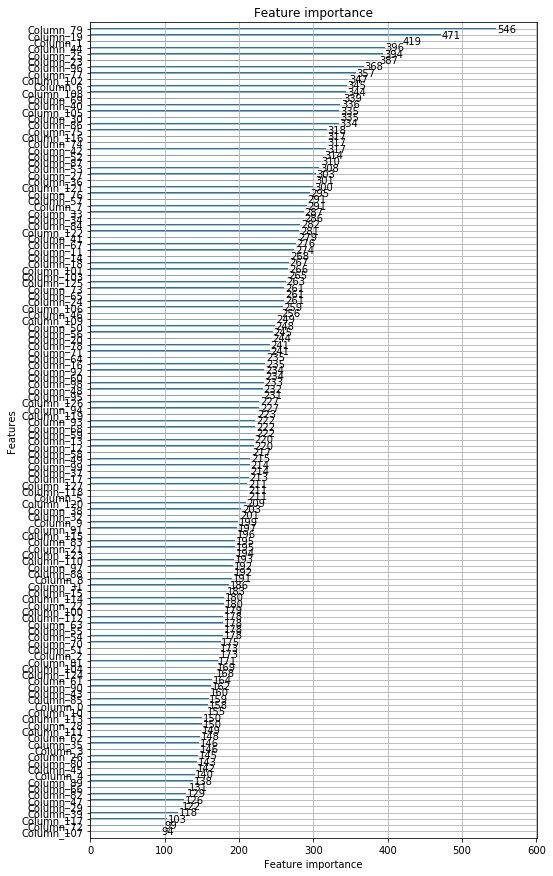

In [6]:
lgb.plot_importance(gbm, figsize=(8,15))
plt.show()

In this stape, I used a pakage whose name is 'Light GBM'(designed by Microsoft). It is a gradient boosting framework that uses tree based learning algorithms. The most important function that I have used in my challenge is 'feature_importance'. It is a function that could help us to know the importance of each feature(by the number of times a feature is used in a model). In fact, in the package of sklearn, we also have some feature selection functions like 'selectkBest'. However, I found that the performance of lightgbm is better. What's more, it has a fast training speed as well.<br><br>
For the parameters, I choose to set n_feature as 116(I have tried 100 and 120, with the same parameters below, 116 performs better). As shown in the graph above, the importances of features have a great difference.

## Stape 2: Sample Selection

In [38]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X_lgb)
distances, indices = nbrs.kneighbors(X_test_lgb)
index_knn = np.ravel(indices)

In [39]:
print index_knn.shape
index_unique = np.unique(index_knn)
X_knn = X_lgb[index_unique]
y_knn = y_train[index_unique]
print X_knn.shape, y_knn.shape

(84960,)
(40605, 120) (40605,)


At first, I chose to use all the samples to do the training, but I found that it is not only slow, but also not
that accurate. After checking the output of the estimator, I found that the number of '1' is much more than the number of '0'. So I began to consider to use the 'NearestNeighbors' to calculate the most nearest neighbors of test data. The algorithm here is 'The ball tree nearest-neighbor algorithm'.<br>
For the parameters, I have choosed most 10 nearest samples, so I can get about 40 percents of original samples

## Stape 3: Train Test Split

In [56]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_knn, y_knn,
                                                            train_size=0.95, test_size=0.05, random_state=42)

This stape is quite simple. Using 'train_test_split' functino is OK. At the very beginning, I try to use cross validation to do the parameter tuning, but it is too slow even if I only used 20 percents of training samples.

## Stape 4: PCA

In [57]:
pca = PCA(svd_solver='randomized', n_components=n_feature-2, whiten=True)
X_train_pca = pca.fit_transform(X_train_1)

In this stape, I chose to use PCA to do the dimensionality reduction and I reduced the number of feature again to 118.

## Stape 5: MLP and Bagging

In [81]:
alpha = 3
size_mlp = y_train_1.shape[0]/(alpha*(2+n_feature-2))
print size_mlp
clf = BaggingClassifier(MLPClassifier(hidden_layer_sizes=(size_mlp, size_mlp, size_mlp, size_mlp)),
                        n_estimators=50, max_features=0.7, max_samples=0.7, n_jobs=-1)
clf.fit(X_train_pca, y_train_1)

107


BaggingClassifier(base_estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(107, 107, 107, 107), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.7,
         max_samples=0.7, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

The main estimator that I used is Bagging. For the estimator Bagging, we should to use an estimator which is relatively high variance. So MLP is a good choice.<br>
However, it is very important to set the parameters of MLP. Because when I set a too large layer_sizes, the result will be overfitting. Actually, this a formula about the choice of size:
$$N_h=\frac{N_{train samples}}{\alpha*(N_{output}+N_{feature})}$$

## Stape 6: Tuning of threshold

thre:0.760000
score:0.100935


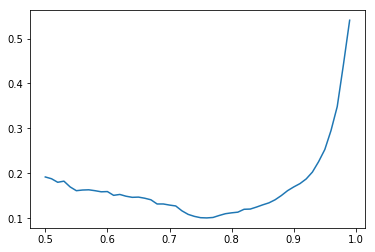

In [98]:
threshold = 0
X_test_pca = pca.transform(X_test_1)
y_pred = clf.predict(X_test_pca)
y_pred_pro = clf.predict_proba(X_test_pca)

score = 1
scores = []
for i in np.arange(0.5, 1, 0.01):
    y_pred_1 = uncerAjustPro(y_pred, y_pred_pro, i)
    temp = compute_pred_score(y_pred_1, y_test_1)
    scores.append(temp)
    if temp < score:
        score = temp
        threshold = i
print 'thre:%f' %threshold
print 'score:%f' %score
plt.figure()
plt.plot(np.arange(0.5, 1, 0.01), scores)
plt.show()

Here I make a prediction for the rest part that we splited from the traing data. As we can see in the graph, when the probability is between 0.7-0.8, the prediction is highest.

## Stape 7: Prediction

In [90]:
X_test_pca1 = pca.transform(X_test_lgb)
y_pred = clf.predict(X_test_pca1)
y_pred_pro = clf.predict_proba(X_test_pca1)
y_pred = uncerAjustPro(y_pred, y_pred_pro, threshold)
print list(y_pred).count(0)
np.savetxt('y_pred_bagging.txt', y_pred, fmt='%d')

422
